In [1]:
from typing import Annotated

from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, END ,START
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage ,RemoveMessage,AIMessage
from langchain_openai import ChatOpenAI
from langchain.tools import DuckDuckGoSearchResults
from groq import Groq
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from typing import List, Dict
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain.tools import DuckDuckGoSearchResults
from groq import Groq
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
memory = MemorySaver()
api_key="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"
llm=ChatGroq(groq_api_key=api_key)
llm

import pandas as pd


def load_doctors_data():
    """Load doctors data from CSV"""
    try:
        return pd.read_csv('data.csv')
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

def save_doctors_data(df):
    """Save doctors data to CSV"""
    try:
        # Force writing to disk by using mode='w'
        df.to_csv('data.csv', index=False, mode='w')
        return True
    except Exception as e:
        print(f"Error saving CSV: {e}")
        return False

    
class State(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
    doctor_name: str  # Name of the doctor
    issue: str  # Issue/description of the appointment
    day: str  # Day of the appointment
    time: str  # Time of the appointment


def chatbot(state: State):
    try:
        return {"messages": [llm.invoke(state["messages"])]}
    except Exception as e:
        error_message = f"An error occurred while processing your request. Please try again later."
        return {"messages": [AIMessage(content=error_message)]}
    
    
def extract_doctor_name(state: State):
    """
    Extracts the doctor's name from the latest message.
    Checks if the name exists in the database before updating the state.
    Returns None if no update is needed.
    """
    try:
        # If doctor details already exist in state, return None
        if state.get("doctor_name"):
            return None

        # Load the DataFrame
        df = load_doctors_data()
        if df is None or df.empty:
            return None
        
        # Get the latest message
        messages = state.get("messages", [])
        if not messages:
            return None  # No messages to process

        latest_message = messages[-1].content

        # Create a prompt to extract the doctor's full name
        extraction_prompt = f"""
            Extract the first name of the doctor from the following message. If no doctor's name is found, return `None`.

            Message: {latest_message}

            Instructions:
            1. Extract the doctor's first name only.
            2. Format the extracted name as: `Dr. <FirstName>`.
            - Example 1: If the name is "Ram Bahadur", return `Dr. Ram`.
            - Example 2: If the name is "Smith Thapa", return `Dr. Smith`.
            - Example 3: If the name is "Sudip Majkoti", return `Dr. Sudip`.
            3. If no doctor's name is found, return `None`.
            - Example 4: If the message is "Hello, I need an appointment.", return `None`.
            - Example 5: If the message is "Can I book an appointment for tomorrow?", return `None`.

            Important:
            - Do not return anything other than the extracted name in the format `Dr. <FirstName>` or `None`.
            - Do not include any explanations, additional text, or formatting.
            """
        # Ask the LLM to extract the doctor's name
        response = llm.invoke([HumanMessage(content=extraction_prompt)])
        extracted_name = response.content.strip()

        
        # Ensure LLM output is not empty
        if extracted_name == "None":
            return None

        # Get the list of valid doctor names from the database
        doctor_names = df["name"].str.strip().unique().tolist()

        # Check if the extracted name exists in the database
        if extracted_name in doctor_names:
            # Update the state with the extracted doctor's name
            return {"doctor_name": extracted_name}
        
        return None  # No valid doctor name found in the database

    except Exception as e:
        print(f"Error extracting doctor's information: {e}")
        return None

    
def extract_appointment_day(state: State):
    """
    Extracts the appointment day from the conversation history.
    Checks if the day exists and updates the state if a new day is found.
    """
    try:
        # If the appointment day details already exist in state, return the state
        if state.get("day"):
            return None  # Appointment day already exists, no need to extract
        
        
     # Load the DataFrame
        df = load_doctors_data()
        if df is None or df.empty:
            return None

        # Get the latest message
        messages = state.get("messages", [])
        if not messages:
            return state  # No messages to process

        latest_message = messages[-1].content

        # Create a prompt to extract the appointment day
        extraction_prompt = f"""
        Extract the appointment day from the following message. If no day is found, return `None`. Return ONLY the day or `None`, nothing else.

        Message: {latest_message}

        Instructions:
        1. Extract the day of the week explicitly mentioned in the message.
        2. Return the day exactly as it appears in this list: `Monday`, `Tuesday`, `Wednesday`.
        3. If no day from this list is mentioned, return `None`.
        4. Do NOT return any explanations, extra text, punctuation, or formatting beyond the day or `None`.
        5. Do NOT guess or infer days; only extract what is explicitly stated.

        Examples:
        - Message: "I would like to schedule an appointment for Monday at 10am."
        Output: Monday
        - Message: "Please book me for Wednesday."
        Output: Wednesday
        - Message: "Can I come in on Tuesday morning?"
        Output: Tuesday
        - Message: "Hello, I need some information."
        Output: None
        - Message: "Is there any availability?"
        Output: None
        - Message: "Hellow brother"
        Output: None
        - Message: "Book me for Thursday"
        Output: None
        - Message: "Monday is good"
        Output: Monday
        - Message: "See you next week"
        Output: None
        - Message: "What about wednesday afternoon?"
        Output: Wednesday

        Critical:
        - Output MUST be one of: `Monday`, `Tuesday`, `Wednesday`, or `None`.
        - NO additional words, spaces, or characters allowed.
        """


        # Ask the LLM to extract the appointment day
        response = llm.invoke([HumanMessage(content=extraction_prompt)])
        response_text = response.content.strip()

        if response_text =="None":
            return None
        # Check against the full list of days first
        normalized_response = response_text.capitalize()
        # Only check the DataFrame if it’s a valid day
        valid_days = df["day"].str.strip().unique().tolist()
        if normalized_response in valid_days:
            return {"day": normalized_response}
        
        return None

    except Exception as e:
        print(f"Error in extract_appointment_day: {e}")
        return None
    


def extract_appointment_time(state: State):
    """
    Extracts the appointment time from the conversation history.
    Checks if the time is valid and updates the state if a new time is found.
    """
    try:
        if state.get("time"):
            return None
        
        df = load_doctors_data()
        if df is None or df.empty:
            return None

        messages = state.get("messages", [])
        if not messages:
            return None
        
        latest_message = messages[-1].content

        # Define the full list of valid times based on your database
        all_valid_times = ["11am", "12pm", "1pm", "2pm", "3pm", "4pm"]

        extraction_prompt = f"""
        Extract the appointment time from: "{latest_message}". Return ONLY the time or `None`.

        Instructions:
        - Return one of: 11am, 12pm, 1pm, 2pm, 3pm, 4pm.
        - If no time is explicitly mentioned, return `None`.
        - Match the time exactly as shown (case-insensitive), but return it as listed.
        - Examples:
          - "Book at 11am" → 11am
          - "Schedule for Tuesday at 1pm" → 1pm
          - "Hello there" → None
          - "Book one appointment with doctor smith at monday at 12pm" → 12pm
          - "See you at 3pm" → 3pm
        """
        
        response = llm.invoke([HumanMessage(content=extraction_prompt)])
        response_text = response.content.strip()
        
        if response_text == "None":
            return None
        
        # Check against the full list of valid times first
        normalized_response = response_text.lower()  # Times in database are lowercase (e.g., "11am")
        if normalized_response not in all_valid_times:
            return None  # If not a valid time, skip database check
        
        # Only check the DataFrame if it’s a valid time
        valid_times = df["time"].str.strip().unique().tolist()
        if normalized_response in valid_times:
            return {"time": normalized_response}
        
        return None

    except Exception as e:
        print(f"Error in extract_appointment_time: {e}")
        return None


def print_state(state: State):
    """
    Prints the current state information for debugging purposes.
    Returns None to indicate no state updates.
    """
    print("\n--- Current State ---")
    print(f"Messages: {state.get('messages', [])}")
    print(f"Doctor Name: {state.get('doctor_name', 'Not set')}")
    print(f"Issue: {state.get('issue', 'Not set')}")
    print(f"Day: {state.get('day', 'Not set')}")
    print(f"Time: {state.get('time', 'Not set')}")
    print("--------------------\n")
    return None


@tool
def appointment(state: State):
    """
    Schedule an appointment with a doctor using information from the state.
    Updates the CSV file to mark the slot as booked.
    """
    try:
        df = load_doctors_data()
        if df is None or df.empty:
            return {"messages": [AIMessage(content="Error accessing appointment system or no data available.")]}

        # Extract details from the state
        requested_doctor = state.get("doctor_name")
        requested_day = state.get("day")
        requested_time = state.get("time")

        if not all([requested_doctor, requested_day, requested_time]):
            return {"messages": [AIMessage(content="Missing information in the state. Please provide doctor name, day, and time.")]}

        # Check availability
        available_slot = df[
            (df['name'] == requested_doctor) & 
            (df['day'] == requested_day) & 
            (df['time'] == requested_time) &
            (df['status'] == 'free')
        ]

        if available_slot.empty:
            return {"messages": [AIMessage(content=f"Sorry, the slot with {requested_doctor} on {requested_day} at {requested_time} is not available.")]}

        # Book the appointment
        slot_index = available_slot.index[0]
        df.at[slot_index, 'status'] = 'booked'

        success = save_doctors_data(df)
        if not success:
            return {"messages": [AIMessage(content="Error saving appointment. Please try again.")]}

        slot = available_slot.iloc[0]
        return {"messages": [AIMessage(content=f"Appointment scheduled successfully with {slot['name']} ({slot['specialization']}) on {slot['day']} at {slot['time']}")]}

    except Exception as e:
        return {"messages": [AIMessage(content=f"Error scheduling appointment: {str(e)}")]}
    

@tool
def cancelappointment(state: State):
    """
    Cancel an existing appointment using information from the state.
    """
    try:
        df = load_doctors_data()
        if df is None or df.empty:
            return {"messages": [AIMessage(content="Error accessing appointment system or no data available.")]}

        # Extract details from the state
        requested_doctor = state.get("doctor_name")
        requested_day = state.get("day")
        requested_time = state.get("time")

        if not all([requested_doctor, requested_day, requested_time]):
            return {"messages": [AIMessage(content="Missing information in the state. Please provide doctor name, day, and time.")]}

        # Find booked appointments
        mask = (df['name'] == requested_doctor) & (df['status'] == 'booked')
        if requested_day:
            mask &= (df['day'] == requested_day)
        if requested_time:
            mask &= (df['time'] == requested_time)

        booked = df[mask]

        if booked.empty:
            return {"messages": [AIMessage(content=f"No booked appointments found for {requested_doctor} on {requested_day} at {requested_time}.")]}

        # Cancel appointments
        cancelled = []
        for idx, slot in booked.iterrows():
            df.at[idx, 'status'] = 'free'
            cancelled.append(f"{slot['day']} at {slot['time']}")

        # Save changes to CSV
        if save_doctors_data(df):
            appointments_str = "\n- ".join(cancelled)
            return {"messages": [AIMessage(content=f"Successfully cancelled the following appointments with {requested_doctor}:\n- {appointments_str}")]}
        else:
            return {"messages": [AIMessage(content="Error cancelling appointment. Please try again.")]}

    except Exception as e:
        return {"messages": [AIMessage(content=f"Error cancelling appointment: {str(e)}")]}

tool_node = ToolNode(tools=[appointment, cancelappointment])
# Define the tools list (for binding to LLM, etc.)
# Define the tools list (for binding to LLM, etc.)
tools = [appointment, cancelappointment]
llm_with_tools = llm.bind_tools(tools=tools)

# Build the graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_node("extract_doctor_name", extract_doctor_name)
graph_builder.add_node("extract_appointment_day", extract_appointment_day)
graph_builder.add_node("extract_appointment_time", extract_appointment_time)
graph_builder.add_node("printstate", print_state)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "extract_doctor_name")
"""
graph_builder.add_edge("extract_doctor_name","extract_appointment_day")
graph_builder.add_edge("extract_appointment_day","extract_appointment_time")
"""
graph_builder.add_edge("extract_doctor_name", "chatbot")
graph_builder.add_edge("chatbot","printstate")

graph_builder.add_conditional_edges(
    "chatbot",tools_condition
)
graph_builder.add_edge("tools", "chatbot")

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)
# Config setup for graph execution
config = {"configurable": {"thread_id": "7"}}

In [45]:
user_input = "book one appointment with doctor smith at monday at 12pm"
''''''
'''book one appointment with doctor smith at monday at 12pm'''

# The config is the **second positional argument** to stream() or invoke()!
result= graph.invoke(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)



--- Current State ---
Messages: [HumanMessage(content='book one appointment with doctor smith at monday at 12pm', additional_kwargs={}, response_metadata={}, id='d418c568-0dd1-43f5-900c-1ea4db21ec7c'), AIMessage(content='Sure, I can help you with that. Here\'s an example of how you might word your request:\n\n"Hi there, I would like to book one appointment with Dr. Smith for Monday at 12pm. Can you help me with that, please?"\n\nI hope this helps! Let me know if you have any other questions.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 22, 'total_tokens': 96, 'completion_time': 0.11318281, 'prompt_time': 0.002907781, 'queue_time': 0.021599486, 'total_time': 0.116090591}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None}, id='run-ecdaa43d-6486-448b-ac1e-d2078a8ed8a4-0', usage_metadata={'input_tokens': 22, 'output_tokens': 74, 'total_tokens': 96})]
Doctor Name: Dr.

In [ ]:
book one appointment with doctor smith at monday at 12pmuser_input = ""

# Example user message (you can replace this with actual input)
messages = [{"role": "user", "content": user_input}]

# Invoke the graph with the user message
response = graph.invoke({"messages": messages}, config)

# Print the last message in the response
response["messages"][-1].pretty_print()



================================== Ai Message ==================================

Certainly! Here's an example of how you could request to book one appointment with Doctor Smith on Monday at 12pm:

"Hi there, I would like to book one appointment with Doctor Smith for Monday at 12pm. Could you please let me know if that time is available and help me with the booking process? Thank you!"

Please note that this is just a general template, and you may need to provide additional information or follow specific steps depending on the system or process used by Doctor Smith's office. It's always a good idea to check with the office directly for their preferred method of booking appointments.


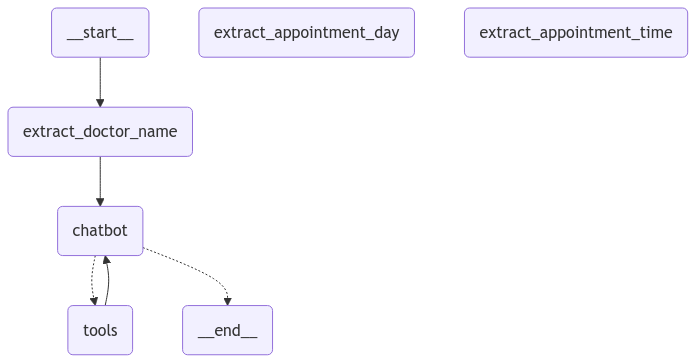

In [88]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='make one appointment for me with doctor smith on moday at 11 am', additional_kwargs={}, response_metadata={}, id='56558eb6-548c-4e55-ba62-1271b9107b03'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bkq5', 'function': {'arguments': '{"query":"make an appointment with doctor smith on monday at 11 am"}', 'name': 'appointment'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1596, 'total_tokens': 1698, 'completion_time': 0.156978797, 'prompt_time': 0.184637659, 'queue_time': 0.019783633999999994, 'total_time': 0.341616456}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-17a6f27a-4a1f-4d62-87cc-50e7e68f8be6-0', tool_calls=[{'name': 'appointment', 'args': {'query': 'make an appointment with doctor smith on monday at 11 am'}, 'id': 'call_bkq5', 'type': 'tool_call'}], usage_m

In [16]:
result=info_chain({"messages": [{"role": "user", "content": "I want to create a prompt template"}]})
print(result)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yym1', 'function': {'arguments': '{"constraints":[],"objective":"Create a prompt template","requirements":[],"variables":["prompt template"]}', 'name': 'PromptInstructions'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 1388, 'total_tokens': 1512, 'completion_time': 0.191440317, 'prompt_time': 0.083991875, 'queue_time': 0.018998151000000005, 'total_time': 0.275432192}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f29abd0c-d20e-4289-b36e-018169115b2e-0', tool_calls=[{'name': 'PromptInstructions', 'args': {'constraints': [], 'objective': 'Create a prompt template', 'requirements': [], 'variables': ['prompt template']}, 'id': 'call_yym1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1388, 'output_tokens': 124, 'total_tokens': 1512})]}


In [33]:
result=extract_doctor_name({"messages": [{"role": "user", "content": "book one appointment with doctor smith at monday at 12pm"}]})
print(result)

Error extracting doctor's name: 'dict' object has no attribute 'content'
None


In [46]:
extraction_prompt = f"""
            Extract the first name of the doctor from the following message. If no doctor's name is found, return `None`.

            Message: {"sudip majkoti"}

            Instructions:
            1. Extract the doctor's first name only.
            2. Format the extracted name as: `Dr. <FirstName>`.
            - Example 1: If the name is "Ram Bahadur", return `Dr. Ram`.
            - Example 2: If the name is "Smith Thapa", return `Dr. Smith`.
            - Example 3: If the name is "Sudip Majkoti", return `Dr. Sudip`.
            3. If no doctor's name is found, return `None`.
            - Example 4: If the message is "Hello, I need an appointment.", return `None`.
            - Example 5: If the message is "Can I book an appointment for tomorrow?", return `None`.

            Important:
            - Do not return anything other than the extracted name in the format `Dr. <FirstName>` or `None`.
            - Do not include any explanations, additional text, or formatting.
            """

df = load_doctors_data()
response = llm.invoke([HumanMessage(content=extraction_prompt)])
print(response.content)
extracted_name = response.content.strip()
print(extracted_name)

if extracted_name == "None":
        print("None")

        # Get the list of valid doctor names from the database
doctor_names = df["name"].str.strip().unique().tolist()
print(doctor_names)


if extracted_name in doctor_names:
        print(extracted_name)
              # Check if the extracted name exists in the database

        

Dr. Sudip
Dr. Sudip
['Dr. Smith', 'Dr. Johnson', 'Dr. Brown', 'Dr. Williams']


In [43]:
extraction_prompt = f"""
Extract the appointment day from the following message. If no day is found, return `None`. Return ONLY the day or `None`, nothing else.

Message: {"book one appointment with doctor smith at monday at 12pm"}

Instructions:
1. Extract the day of the week explicitly mentioned in the message.
2. Return the day exactly as it appears in this list: `Monday`, `Tuesday`, `Wednesday`.
3. If no day from this list is mentioned, return `None`.
4. Do NOT return any explanations, extra text, punctuation, or formatting beyond the day or `None`.
5. Do NOT guess or infer days; only extract what is explicitly stated.

Examples:
- Message: "I would like to schedule an appointment for Monday at 10am."
  Output: Monday
- Message: "Please book me for Wednesday."
  Output: Wednesday
- Message: "Can I come in on Tuesday morning?"
  Output: Tuesday
- Message: "Hello, I need some information."
  Output: None
- Message: "Is there any availability?"
  Output: None
- Message: "Hellow brother"
  Output: None
- Message: "Book me for Thursday"
  Output: None
- Message: "Monday is good"
  Output: Monday
- Message: "See you next week"
  Output: None
- Message: "What about wednesday afternoon?"
  Output: Wednesday

Critical:
- Output MUST be one of: `Monday`, `Tuesday`, `Wednesday`, or `None`.
- NO additional words, spaces, or characters allowed.
"""


        # Ask the LLM to extract the appointment day
response = llm.invoke([HumanMessage(content=extraction_prompt)])
print(response.content)
response_text = response.content.strip()
print(response_text)



Monday
Monday
